In [23]:
from mmdet.datasets import build_dataset, build_dataloader
import pycocotools
import cv2, torch
import numpy as np
import matplotlib.pyplot as plt

In [141]:
dataset_type = 'LogMiniDet'
data_root = '/mnt/d/Github/mmdetection2/project/LogMiniDet/data/0428/'
img_scale = (1024, 1024)
img_norm_cfg = dict(
    mean=[123.68, 116.779, 103.939], std=[58.393, 57.12, 57.375], to_rgb=True)
load_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    #dict(type='Normalize', **img_norm_cfg),
]

train_pipeline = [
    dict(type='Mosaic', img_scale=img_scale, pad_val=114.0),
    dict(
        type='RandomAffine',
        scaling_ratio_range=(0.5, 1.5),
        max_rotate_degree=15,
        border=(-img_scale[0] // 2, -img_scale[1] // 2)),
    dict(
        type='MixUp',
        img_scale=img_scale,
        ratio_range=(0.7, 1.8),
        pad_val=114.0),
    dict(type='YOLOXHSVRandomAug'),
    #dict(type='Rotate', level=1, max_rotate_angle=30, prob=0.5),
    dict(type='RandomFlip', flip_ratio=[0.2, 0.2, 0.2], direction=['horizontal', 'vertical', 'diagonal']),
    # According to the official implementation, multi-scale
    # training is not considered here but in the
    # 'mmdet/models/detectors/yolox.py'.
    dict(type='Resize', img_scale=img_scale, keep_ratio=True),
    dict(
        type='Pad',
        pad_to_square=True,
        # If the image is three-channel, the pad value needs
        # to be set separately for each channel.
        pad_val=dict(img=(114.0, 114.0, 114.0))),
    #dict(type='CopyPaste',max_num_pasted=50,),
    dict(type='FilterAnnotations', min_gt_bbox_wh=(1, 1), keep_empty=False),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=[(1200, 1200), (2048, 2048), (600, 600)],
        flip=True,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
train_dataset = dict(
    type='MultiImageMixDataset',
    dataset=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations/train.json',
        img_prefix=data_root + 'train/',
        pipeline=load_pipeline,
        filter_empty_gt=False),
    pipeline=train_pipeline,
    num_workers=2,)
data = dict(
    samples_per_gpu=2,
    workers_per_gpu=1,
    train=train_dataset,
    val=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations/val.json',
        img_prefix=data_root + 'val/',
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations/val.json',
        img_prefix=data_root + 'val/',
        pipeline=test_pipeline))

In [142]:
dataset = build_dataset(train_dataset)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


/mnt/d/Github/mmdetection2/mmdet/datasets/api_wrappers/coco_api.py:22: UserWarning: mmpycocotools is deprecated. Please install official pycocotools by "pip install pycocotools"
  UserWarning)


TypeError: __init__() got an unexpected keyword argument 'num_workers'

In [86]:
palette = dataset.PALETTE
class_name = dataset.CLASSES

In [101]:
dataset[0]['img_metas'].data['img_shape']

(1024, 1024, 3)

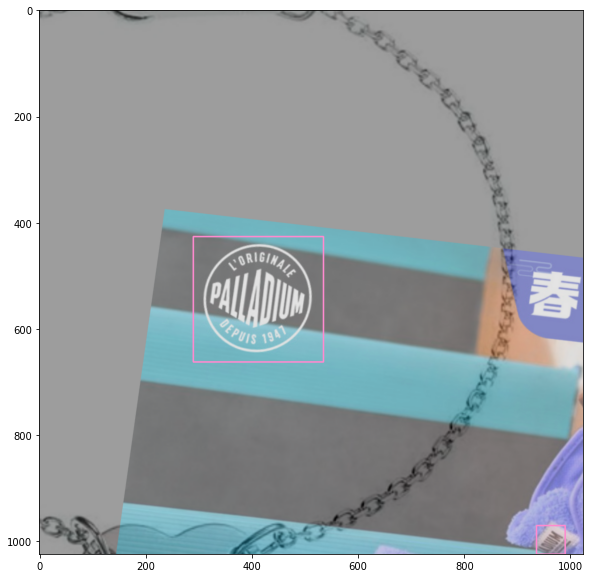

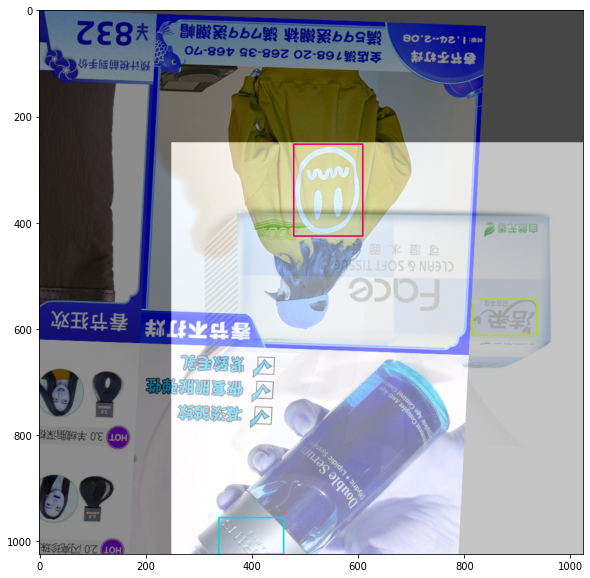

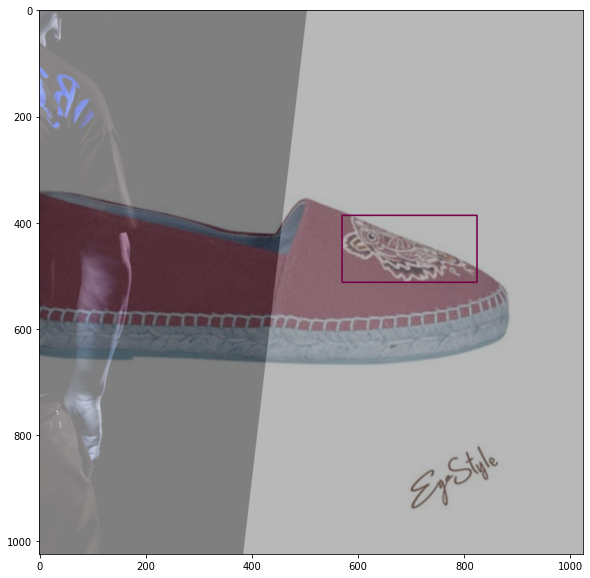

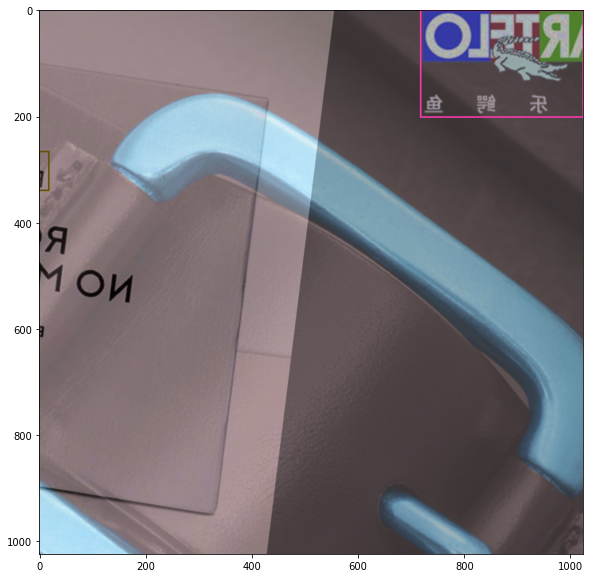

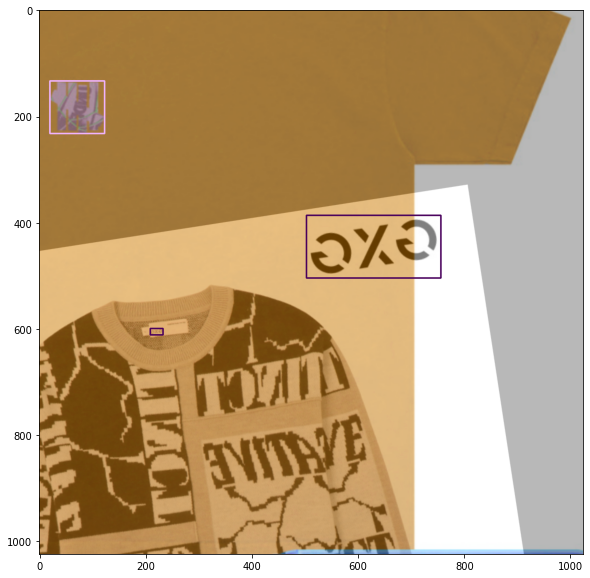

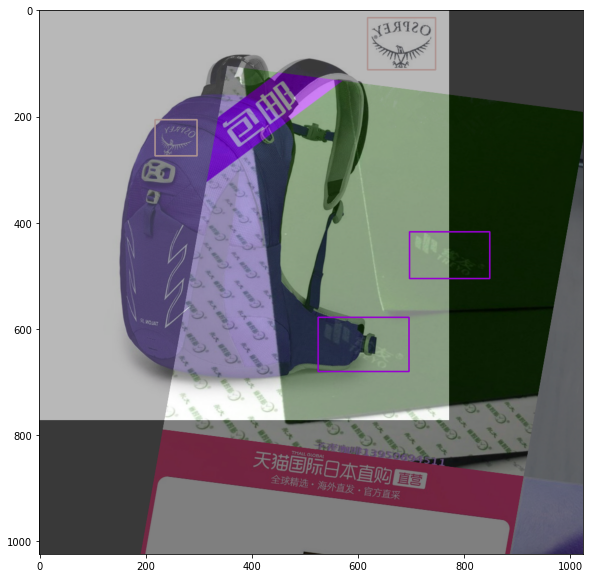

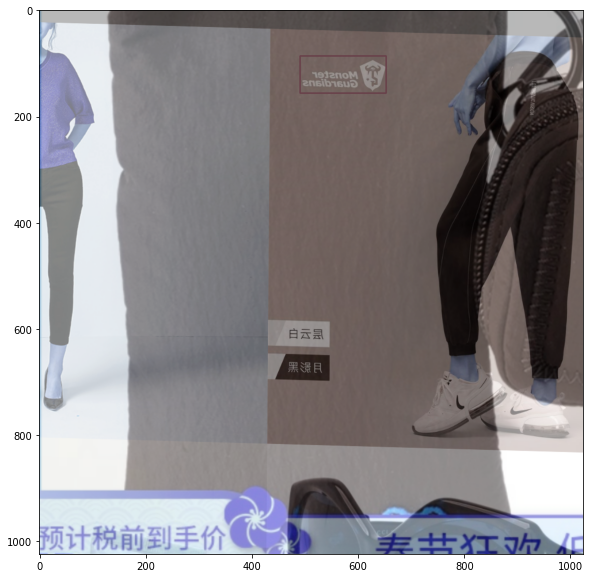

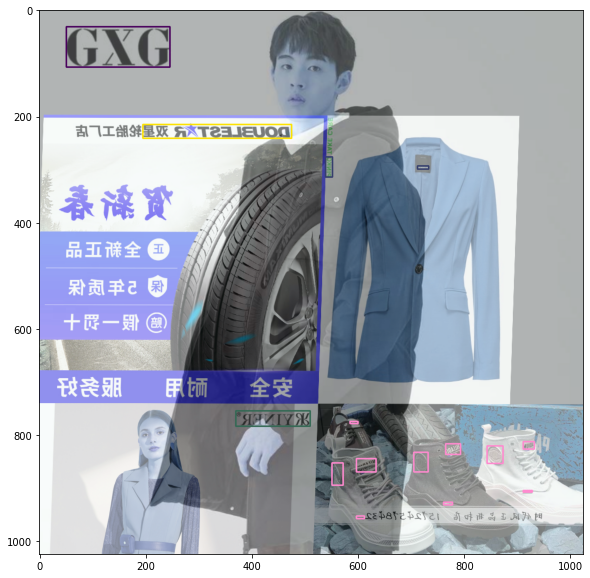

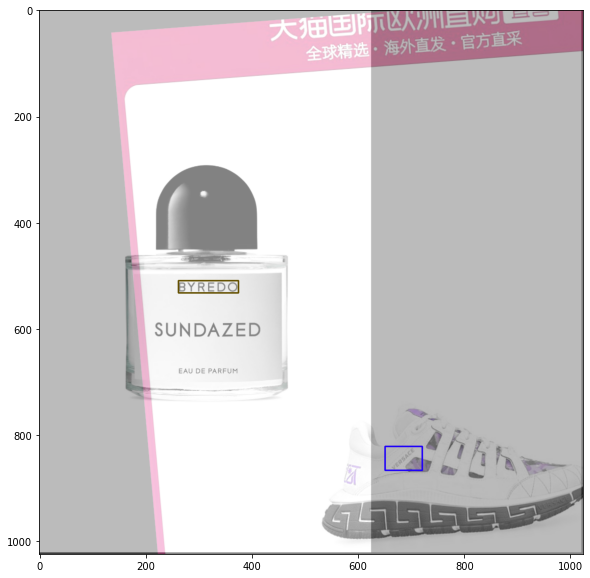

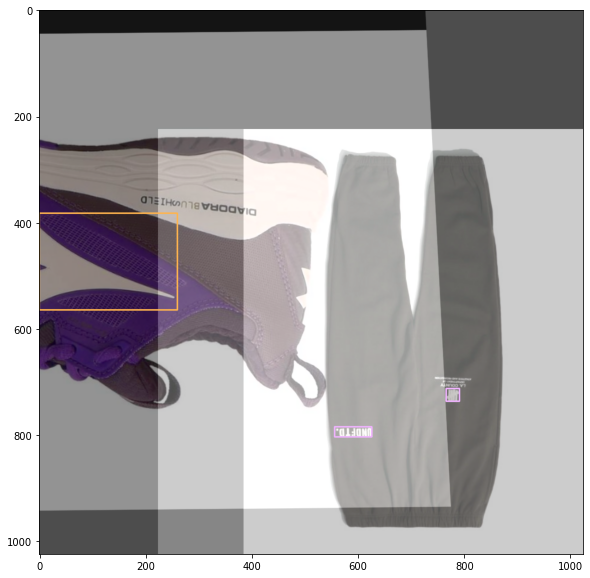

In [140]:
import random


index = random.sample(range(0,len(dataset)),10)
for i in index:
    img = dataset[i]
    plt.figure(figsize=[10,10])
    image = img['img'].data.numpy()
    image = np.transpose(image, (1,2,0))
    image = cv2.cvtColor(np.uint8(image), cv2.COLOR_RGB2BGR)
    bboxes = img['gt_bboxes'].data.numpy()
    bboxes = bboxes.astype(np.int)
    for j, bbox in enumerate(bboxes):
        image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2],bbox[3]), color=palette[img['gt_labels'].data[j]], thickness=2)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [76]:
bbox.astype(np.int)

array([ 59, 370, 488, 450])